In [5]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits
import astropy.wcs as wcs
from astropy.coordinates import SkyCoord
from astropy import units as u

from astropy_healpix import HEALPix

### read data
hpmapfname = "xrbkg_rayspec.fits"
hdul = pyfits.open(hpmapfname)
hdu = hdul[1]   ### model photon flux

specdata = hdu.data.field(0)
vedges  = np.linspace(0.1, 10.0, 1981)
ebinw   = 0.005 # keV

nside    = hdu.header['NSIDE']
ordering = hdu.header['ORDERING']
#coordsys = hdu.header['COORDSYS']
coordsys = 'icrs' # fk5
hp = HEALPix(nside, ordering, coordsys)


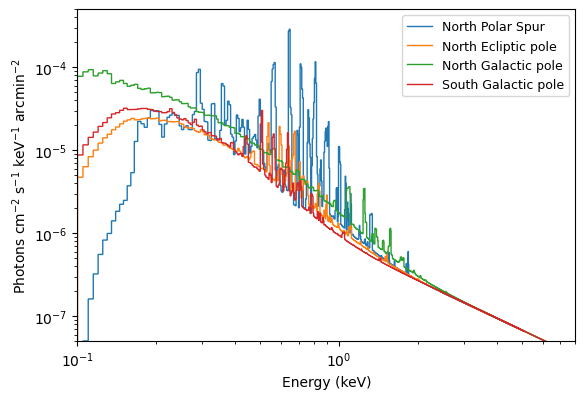

In [6]:
#### plot spectra
vradec = np.array([
    [260.587500, 4.756667],  ### North Polar Spur
    [272.800000, 66.000000], ### North Ecliptic pole
    [192.859481, 27.128251], ### North Galactic pole
    [12.859481, -27.128251], ### South Galactic pole
],'float64')

speclab_list = [
    "North Polar Spur   ",
    "North Ecliptic pole",
    "North Galactic pole",
    "South Galactic pole",
]

vskycoord = SkyCoord(vradec.T[0], vradec.T[1], frame=coordsys, unit='deg') 
#print(vskycoord)
vhpxidx = hp.skycoord_to_healpix(vskycoord)
#print(vhpxidx)


fig, ax = plt.subplots(figsize=(6,4))
fig.subplots_adjust(left=0.12, right=0.95, bottom=0.12, top=0.95)

#ax.set_xlim(0.1, 10.)
ax.set_xlim(0.1, 8.)
ax.set_ylim(0.5e-7, 5.e-4)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Energy (keV)')
ax.set_ylabel('Photons cm$^{-2}$ s$^{-1}$ keV$^{-1}$ arcmin$^{-2}$')

nskycoord = len(vskycoord)
for idx in range(nskycoord) :
    hpxidx = vhpxidx[idx]
    vspec = specdata[hpxidx] / ebinw
    speclab = speclab_list[idx]
    ax.stairs(vspec, vedges, lw=1, label=speclab)
    
ax.legend(loc='upper right', fontsize=9)

Energy band = 0.20-0.52 keV, Ebin range = 20 - 84
Energy band = 0.52-0.91 keV, Ebin range = 84 - 162
Energy band = 0.91-2.00 keV, Ebin range = 162 - 380
zmin, zmax =  4.2509580626611926e-08 0.00023866461175398192
zmin, zmax =  1.3706241563696533e-08 0.000123018199680705
zmin, zmax =  1.7209613917294065e-08 8.080530927993075e-05


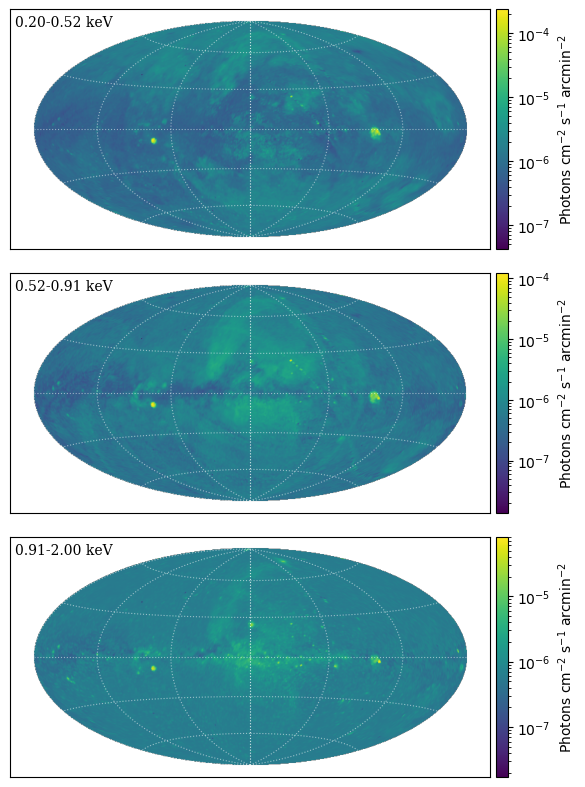

In [7]:
#### plot all-sky map
from reproject import reproject_from_healpix, reproject_to_healpix
from astropy.visualization import make_rgb, make_lupton_rgb, LinearStretch, LogStretch

### wcs
#coordsys = "galactic"
target_header = pyfits.Header.fromstring("""
NAXIS   =                    2
NAXIS1  =                  720
NAXIS2  =                  360
CTYPE1  = 'GLON-AIT'
CRPIX1  =                360.5
CRVAL1  =                  0.0
CDELT1  =               -0.5
CUNIT1  = 'deg     '
CTYPE2  = 'GLAT-AIT'
CRPIX2  =                180.5
CRVAL2  =                  0.0
CDELT2  =                0.5
CUNIT2  = 'deg     '
COORDSYS= 'icrs    '
""", sep='\n')
w  = wcs.WCS(target_header)

datatype = np.float64 #'float64' ### float32
ny = w.array_shape[0]
nx = w.array_shape[1]


### 3 band 
ebandlim_list = [
    #[0.3,  0.6], # keV  eROSITA map
    #[0.6,  1.0], # 
    #[1.0,  2.3]  # 
    [0.20, 0.52], # keV  ROSAT map
    [0.52, 0.91], # 
    [0.91, 2.00]  # 
]

ebandtitle_list = []

rgblist = [
    "red", "green", "blue"
]

rgbimglist = []

#ngrp = len(ebinlim_list)
ngrp = 3 

for igrp in range(ngrp) :
    #ebinle = ebinlim_list[igrp][0]
    #ebinhe = ebinlim_list[igrp][1]
    ebandle = ebandlim_list[igrp][0]
    ebandhe = ebandlim_list[igrp][1]
    ebinle = np.argmin(np.fabs((vedges - ebandle)))
    ebinhe = np.argmin(np.fabs((vedges - ebandhe)))
    print("Energy band = %.2lf-%.2lf keV, Ebin range = %d - %d"%(ebandle, ebandhe, ebinle, ebinhe))
    #ebandgrp = ebandgrp_list[igrp]
    #img = np.zeros((ny,nx), datatype)
    #for ebandidx in ebandgrp :
    #hmap = hdu.data.field(ebandidx)
    hmap = specdata[:, ebinle:ebinhe].sum(axis=1)
    #print(hmap)
    array, footprint = reproject_from_healpix((hmap, 'icrs'), target_header,  
                                              order='bilinear', nested=False)
    array = np.nan_to_num(array)
    array *= (array>0.0)
    array *= (ebandhe-ebandle) ### * (eband width)
    #img += array 
    
    #zmax = img.max()
    #zmin = img.min()
    rgbimglist.append(array)
    ebandtitle_list.append("%.2lf-%.2lf keV"%(ebandle, ebandhe))

##### 3 band image #####
fig, axs = plt.subplots(3,1, figsize=(6,8), subplot_kw=dict(projection=w))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.02, top=0.98, wspace=0.1, hspace=0.1)

colormap = 'viridis' ### default
#colormap = 'gray'

for idx in range(ngrp) :
    ax = axs[idx]
    imgdat = rgbimglist[idx]
    zmax = imgdat.max()
    zmin = ((imgdat<1e-20)*1+imgdat).min()
    print("zmin, zmax = ", zmin, zmax)
    im = axs[idx].imshow(imgdat, origin='lower',
                         #vmin=zmin, vmax=zmax,
                         norm='log', cmap=colormap)
    fig.colorbar(im, ax=ax, location='right', pad=0.01,
                 label = 'Photons cm$^{-2}$ s$^{-1}$ arcmin$^{-2}$')
    
    lon = ax.coords['glon']
    lat = ax.coords['glat']
    lon.grid(color='white', alpha=0.5, linestyle='dotted')
    lon.set_ticks( np.linspace(0,360,7) * u.degree)
    lat.grid(color='white', alpha=0.5, linestyle='dotted')
    lat.set_ticks( np.linspace(-90,90,7) * u.degree)

    ebandtitle = ebandtitle_list[idx]
    ax.text(0.01, 0.93, ebandtitle,
            transform = ax.transAxes,
            fontsize=10, fontfamily='serif')

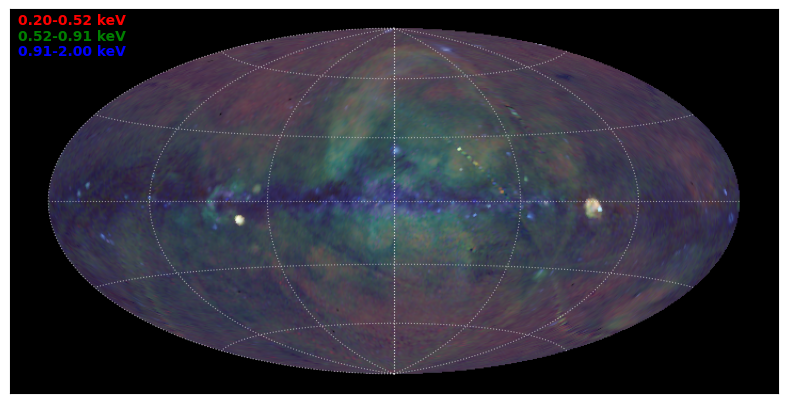

In [8]:
##### RGB image #####
fig, ax = plt.subplots(figsize=(8,4), subplot_kw=dict(projection=w))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.02, top=0.98, wspace=0.1, hspace=0.1)

rgbimg = make_rgb(rgbimglist[0], rgbimglist[1], rgbimglist[2], 
                  stretch=LogStretch(), output_dtype=datatype)
im = ax.imshow(rgbimg, origin='lower')

lon = ax.coords['glon']
lat = ax.coords['glat']

lon.grid(color='white', alpha=0.5, linestyle='dotted')
lon.set_ticks( np.linspace(0,360,7) * u.degree)
lat.grid(color='white', alpha=0.5, linestyle='dotted')
lat.set_ticks( np.linspace(-90,90,7) * u.degree)

ax.text(0.01, 0.96, ebandtitle_list[0], color=rgblist[0],
        transform = ax.transAxes, fontsize=10, fontweight='bold') 
ax.text(0.01, 0.92, ebandtitle_list[1], color=rgblist[1],
        transform = ax.transAxes, fontsize=10, fontweight='bold') 
ax.text(0.01, 0.88, ebandtitle_list[2], color=rgblist[2],
        transform = ax.transAxes, fontsize=10, fontweight='bold') 


plt.ion()
plt.show()